
# 📘 Множественная линейная регрессия в Jupyter: pandas + scikit-learn

Этот ноутбук — пошаговый шаблон:
1. Загружаем CSV в `pandas`
2. Делим признаки/цель
3. Строим пайплайн препроцессинга:
   - числовые: `median impute` + `StandardScaler`
   - категориальные: `most_frequent impute` + `OneHotEncoder`
4. Обучаем `LinearRegression`
5. Оцениваем метрики: R², MAE, RMSE
6. Смотрим важность признаков (коэффициенты)
7. Сохраняем модель на диск (`joblib`)

> ⚙️ Перед запуском укажи путь к своему CSV и имя колонки-цели в блоке **Конфигурация**.


In [ ]:

# (Необязательно) Установка библиотек, если чего-то не хватает.
# В обычной среде Anaconda это всё уже стоит.
# !pip install --upgrade pip
# !pip install pandas scikit-learn matplotlib joblib


In [1]:

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib

RANDOM_STATE = 42



## 🔧 Конфигурация
Заполни переменные ниже:
- `CSV_PATH`: путь к данным
- `TARGET_COLUMN`: имя колонки с целевой переменной (число)
- `DROP_COLUMNS`: колонки, которые не должны попадать в признаки (ID, даты, тексты и т.п.)
- `TEST_SIZE`: доля теста


In [2]:

# === Настройки для твоего проекта ===
CSV_PATH = "/Users/uvauchok/uvauchok-projects/learning/learn-examples/learning-ml/Hyderabad.csv"   # ← ЗАМЕНИ на свой путь, например "/Users/you/data/train.csv"
TARGET_COLUMN = "Price"              # ← ЗАМЕНИ на имя целевой колонки
DROP_COLUMNS = []                     # например: ["id", "timestamp"]
TEST_SIZE = 0.2                       # 20% на тест
RANDOM_STATE = 42

# Быстрая проверка
print("CSV_PATH:", CSV_PATH)
print("TARGET_COLUMN:", TARGET_COLUMN)


CSV_PATH: /Users/uvauchok/uvauchok-projects/learning/learn-examples/learning-ml/Hyderabad.csv
TARGET_COLUMN: Price



## 🗂️ Загрузка данных
`low_memory=False` улучшает чтение смешанных типов. После загрузки посмотрим размер, первые строки и типы.


In [3]:

# Чтение CSV
df = pd.read_csv(CSV_PATH, low_memory=False)

print("Размер датасета:", df.shape)
display(df.head())

print("\nИнформация о столбцах:")
df.info()


Размер датасета: (2518, 40)


,Price,Area,Location,No. of Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,...,LiftAvailable,BED,VaastuCompliant,Microwave,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator
0,6968000,1340,Nizampet,2,0,0,1,1,1,1,...,1,0,1,0,0,0,0,0,0,0
1,29000000,3498,Hitech City,4,0,0,1,1,1,1,...,1,0,1,0,0,0,0,0,0,0
2,6590000,1318,Manikonda,2,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5739000,1295,Alwal,3,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,5679000,1145,Kukatpally,2,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0



Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518 entries, 0 to 2517
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Price                2518 non-null   int64 
 1   Area                 2518 non-null   int64 
 2   Location             2518 non-null   object
 3   No. of Bedrooms      2518 non-null   int64 
 4   Resale               2518 non-null   int64 
 5   MaintenanceStaff     2518 non-null   int64 
 6   Gymnasium            2518 non-null   int64 
 7   SwimmingPool         2518 non-null   int64 
 8   LandscapedGardens    2518 non-null   int64 
 9   JoggingTrack         2518 non-null   int64 
 10  RainWaterHarvesting  2518 non-null   int64 
 11  IndoorGames          2518 non-null   int64 
 12  ShoppingMall         2518 non-null   int64 
 13  Intercom             2518 non-null   int64 
 14  SportsFacility       2518 non-null   int64 
 15  ATM                  2518 non-n


## ✂️ Разделение на признаки и целевую, определение типов признаков
Автоматически определим:
- числовые признаки (`int`, `float`, `bool`)
- категориальные (`object`, `category`)


In [4]:

assert TARGET_COLUMN in df.columns, f"Колонки '{TARGET_COLUMN}' нет в CSV!"

# y — целевая переменная
y = df[TARGET_COLUMN]

# X — признаки (все колонки минус target и явно исключённые)
cols_to_drop = [c for c in DROP_COLUMNS if c in df.columns]
X = df.drop(columns=[TARGET_COLUMN] + cols_to_drop, errors="ignore")

# Определяем типы автоматически
numeric_cols = X.select_dtypes(include=["number", "bool"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

print(f"Числовых признаков: {len(numeric_cols)}")
print(f"Категориальных признаков: {len(categorical_cols)}")

# Покажем примеры
print("\nПримеры числовых:", numeric_cols[:10])
print("Примеры категориальных:", categorical_cols[:10])


Числовых признаков: 38
Категориальных признаков: 1

Примеры числовых: ['Area', 'No. of Bedrooms', 'Resale', 'MaintenanceStaff', 'Gymnasium', 'SwimmingPool', 'LandscapedGardens', 'JoggingTrack', 'RainWaterHarvesting', 'IndoorGames']
Примеры категориальных: ['Location']



## 🧼 Препроцессинг
- Числовые: пропуски → медиана, затем стандартизация
- Категориальные: пропуски → наиболее частое, затем One-Hot

Сделаем так, чтобы на выходе был **плотный массив**, чтобы корректно извлечь имена признаков после One-Hot.


In [6]:

# Один и тот же код будет работать со старыми/новыми версиями sklearn:
ohe_kwargs = {"handle_unknown": "ignore"}
try:
    # Новые версии
    ohe = OneHotEncoder(sparse_output=False, **ohe_kwargs)
except TypeError:
    # Старые версии
    ohe = OneHotEncoder(sparse=False, **ohe_kwargs)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe)
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ],
    remainder="drop"
)



## 🧪 Train/Test split и обучение модели
Используем `Pipeline`: сначала препроцессинг, затем `LinearRegression`.


In [7]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

model = LinearRegression()
pipe = Pipeline(steps=[("preprocess", preprocessor),
                      ("model", model)])

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

r2  = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"R²  = {r2:.4f}")
print(f"MAE = {mae:.4f}")
print(f"RMSE= {rmse:.4f}")


R²  = 0.7652
MAE = 2085315.6450
RMSE= 3847241.4283



## 📈 Визуализация качества
- Предсказания vs Факты
- Гистограмма остатков


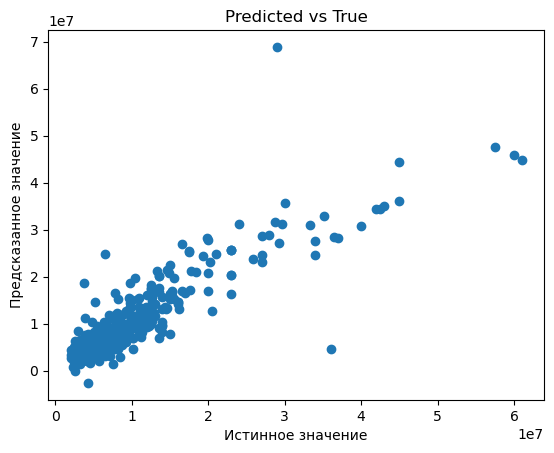

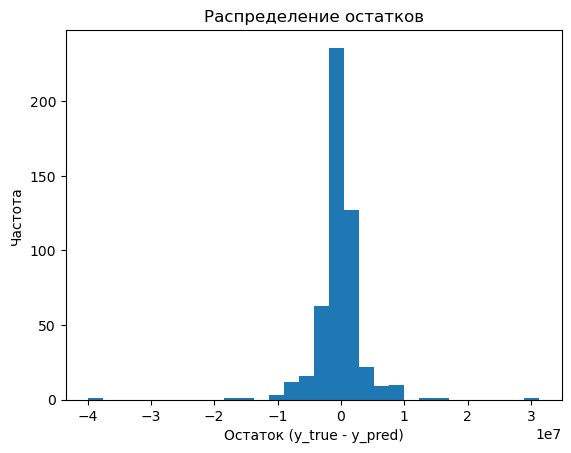

In [8]:

# Предсказанное vs Истинное
plt.figure()
plt.scatter(y_test, y_pred)
plt.xlabel("Истинное значение")
plt.ylabel("Предсказанное значение")
plt.title("Predicted vs True")
plt.show()

# Остатки
residuals = y_test - y_pred
plt.figure()
plt.hist(residuals, bins=30)
plt.xlabel("Остаток (y_true - y_pred)")
plt.ylabel("Частота")
plt.title("Распределение остатков")
plt.show()



## 🔍 Коэффициенты признаков
Для линейной регрессии важно понимать вклад каждого признака. Получим имена **после** One-Hot и вытащим коэффициенты.


In [10]:

# Функция для извлечения имён признаков после препроцессинга
def get_feature_names(preprocessor):
    feature_names = []
    # Числовые имена — как есть
    num_features = preprocessor.named_transformers_["num"].named_steps["imputer"].feature_names_in_
    feature_names.extend(num_features)

    # Категориальные имена — после OneHotEncoder
    if len(categorical_cols) > 0:
        ohe_step = preprocessor.named_transformers_["cat"].named_steps["onehot"]
        try:
            cat_features = ohe_step.get_feature_names_out(categorical_cols)
        except Exception:
            # Старые версии sklearn
            cat_features = ohe_step.get_feature_names(categorical_cols)
        feature_names.extend(list(cat_features))

    return feature_names

# Извлекаем имена и коэффициенты
pre = pipe.named_steps["preprocess"]
lin = pipe.named_steps["model"]
feature_names = get_feature_names(pre)

coef = getattr(lin, "coef_", None)
intercept = getattr(lin, "intercept_", None)

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coef.flatten() if coef.ndim > 1 else coef
}).sort_values(by="coefficient", key=lambda s: s.abs(), ascending=False)

print("Intercept:", intercept)
display(coef_df.head(20))

# Сохраним на диск (удобно для анализа в Excel)
coef_df.to_csv("linear_regression_coefficients.csv", index=False)
print("Файл коэффициентов сохранён как 'linear_regression_coefficients.csv'")


Intercept: 9476729.824640894


,feature,coefficient
40,Location_Abids,1.767061e+07
77,Location_Boiguda,1.625375e+07
217,Location_Sangeet Nagar,-1.411550e+07
230,Location_Sun City,1.207748e+07
126,Location_Janachaitanya Colony,1.112186e+07
104,Location_Film Nagar,1.088316e+07
215,Location_Saket,1.056585e+07
69,Location_Banjara Hills,8.907213e+06
127,Location_Jubilee Hills,8.375794e+06
201,Location_Pocharam,-8.250182e+06


Файл коэффициентов сохранён как 'linear_regression_coefficients.csv'


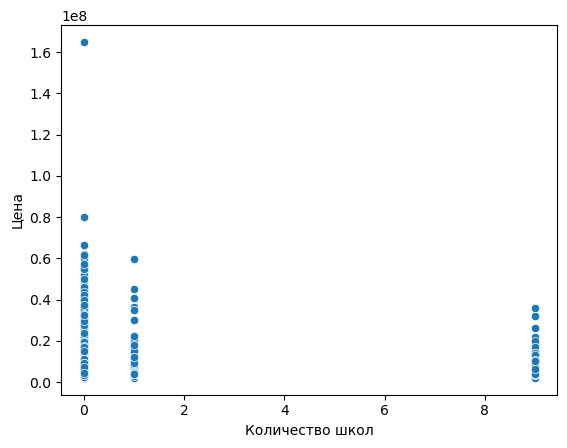

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x=df["School"], y=df["Price"])
plt.xlabel("Количество школ")
plt.ylabel("Цена")
plt.show()


## 🔁 Кросс-валидация (опционально)
Быстрая оценка устойчивости: 5-кратная кросс-валидация по R².


In [13]:

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scores = cross_val_score(pipe, X, y, scoring="r2", cv=cv, n_jobs=None)
print("CV R² mean:", scores.mean(), "±", scores.std())


CV R² mean: 0.7398619441233153 ± 0.15450644558569032



## 💾 Сохранение и загрузка модели
Сохраним весь пайплайн (препроцессинг + модель) в один файл. Потом можно загрузить и сразу использовать `predict`.


In [14]:

joblib.dump(pipe, "linear_regression_pipeline.joblib")
print("Пайплайн сохранён как 'linear_regression_pipeline.joblib'")

# Пример загрузки:
# loaded = joblib.load("linear_regression_pipeline.joblib")
# preds = loaded.predict(X_test)


Пайплайн сохранён как 'linear_regression_pipeline.joblib'



## 🔮 Предсказание на новых данных
Важно передавать **те же имена колонок**, что были в `X` при обучении. Пример ниже показывает, как предсказать на одной строке.


In [15]:

# Сбор "одной новой строки" для предсказания:
# Пример: возьмём первые имена колонок X и зафейкуем значения.
example = {}

for col in X.columns[:5]:  # только первые 5 колонок для короткого примера
    if col in numeric_cols:
        example[col] = float(df[col].median()) if pd.api.types.is_numeric_dtype(df[col]) else 0.0
    else:
        # Если категориальная — берём самое частое значение
        example[col] = df[col].mode(dropna=True)[0] if not df[col].mode(dropna=True).empty else ""

# Остальные нужные колонки тоже должны быть представлены!
# В реальном коде — заполни все столбцы X.
print("Пример (неполный) словаря признаков:", example)

# Для корректного предикта нужен полный набор колонок X.
# В демонстрационных целях создадим строку с теми же колонками, но с заполнителями.
row = {}
for col in X.columns:
    if col in example:
        row[col] = example[col]
    else:
        # Умолчания: 0.0 для числовых, "" для категориальных
        if col in numeric_cols:
            row[col] = 0.0
        else:
            row[col] = ""

new_X = pd.DataFrame([row], columns=X.columns)
pred = pipe.predict(new_X)[0]
print("Предсказание для одной строки:", pred)


Пример (неполный) словаря признаков: {'Area': 1500.0, 'Location': 'Kukatpally', 'No. of Bedrooms': 3.0, 'Resale': 0.0, 'MaintenanceStaff': 0.0}
Предсказание для одной строки: 8440108.923208784


In [18]:
custom_input = {
    "Area": 1000.0,
    "No. of Bedrooms": 3.0
}

# формируем строку со всеми признаками X
row = {}
for col in X.columns:
    if col in custom_input:
        row[col] = custom_input[col]
    else:
        # заполняем умолчаниями
        if col in numeric_cols:
            row[col] = 0.0
        else:
            row[col] = ""

# создаём DataFrame с одной строкой
new_X = pd.DataFrame([row], columns=X.columns)

# делаем предсказание
pred = pipe.predict(new_X)[0]
print("Предсказание для Area=1000 и Bedrooms=3:", pred)

Предсказание для Area=1000 и Bedrooms=3: 2787633.003183839



## 🧠 Советы для больших CSV
- Если файл большой, сначала загрузи **часть колонок** через `usecols=[...]`.
- Проблемы с памятью — можно перейти на `SGDRegressor` (стриминговая линейная модель) или использовать Dask/Modin.
- Даты можно превратить в числовые признаки (год/месяц/день/час и т.п.).
- Всегда фиксируй `random_state` для воспроизводимости.
